In [47]:
import sys
sys.path.insert(1, 'C:/Users/14432/OneDrive/Research/Projects/a549_pcna/scripts/memes/')

import warnings
warnings.filterwarnings("ignore")

import glob
import math
import numpy as np
import os
import random
import shutil

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from os import listdir
from PIL import Image as PImage
from scipy.ndimage.morphology import distance_transform_edt
from scipy.ndimage import binary_fill_holes as fill_holes
from skimage.color import label2rgb
from skimage.io import imread
from skimage.measure import label, regionprops
import skimage.morphology

import hj_util
from pilutil import toimage

In [53]:
main_path = hj_util.folder_verify('C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/train/reg/')
label_path = hj_util.folder_verify(main_path + 'seg/mixer/')
patch_path = hj_util.folder_verify(main_path + 'patch/')

# This will remove smaller images.
im_num = len(glob.glob(label_path + '*crop*'))
# im_num = small_img_remove(label_path)

# patch_size
# round to 32 times
# original setting is 128
train_patch_w=224
train_patch_h=224

test_patch_w=224
test_patch_h=224

#---crop a image by several times to increase samples
patch_copy=10
patch_purity_thres=0.15
patch_trial_thres=100

In [54]:
#generate regression and mask train_test data=patch_path+'bib/'
train_bib_path=patch_path+'bib/'
hj_util.create_folder(train_bib_path)

train_boundary_path=patch_path+'boundary/'
hj_util.create_folder(train_boundary_path)

train_reg_path=patch_path+'bwdist/'
hj_util.create_folder(train_reg_path)

train_img_path=patch_path+'img/'
hj_util.create_folder(train_img_path) 

train_interior_path=patch_path+'interior/'
hj_util.create_folder(train_interior_path) 

C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/train/reg/patch/bib/ folder is freshly created. 

C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/train/reg/patch/boundary/ folder is freshly created. 

C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/train/reg/patch/bwdist/ folder is freshly created. 

C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/train/reg/patch/img/ folder is freshly created. 

C:/Users/14432/OneDrive/Research/Projects/a549_pcna/data/train/reg/patch/interior/ folder is freshly created. 



In [55]:
#random crop image into patches
bib_str=sorted(glob.glob(label_path+ "BIB*.png"))
boundary_str=sorted(glob.glob(label_path+ "boundary*.png"))
bwdist_str=sorted(glob.glob(label_path+ "bwdist*.png"))
img_str=sorted(glob.glob(label_path+ "crop*.png"))
interior_str=sorted(glob.glob(label_path+ "interior*.png"))

In [41]:
train_patch_count=0

for ti in np.arange(len(img_str)):
    
#     bib      = imread(bib_str[ti])
    boundary = imread(boundary_str[ti])
    bwdist   = imread(bwdist_str[ti])
    img      = imread(img_str[ti])
    interior = imread(interior_str[ti])
    
    interior = fill_holes(interior)*1 # this is a one time deal, in the future this should be done in Matlab
    boundary = boundary*(interior==0)*1
    bib = interior + (boundary*2)
    
    img_w, img_h = img_h, img_w = img.shape[0], img.shape[1]
    if img_w < train_patch_w or img_h < train_patch_h:
        i = i+1
        continue
    
    purity = np.sum((interior!=0)*1)/interior.size
    n_patch = round(purity*(img_w*1.0/train_patch_w)*(img_h*1.0/train_patch_h)*patch_copy)
    print('currently cropping '+os.path.basename(img_str[ti]))
    print('    crop purity: '+str(purity)+', target patch number: '+ str(n_patch))
    
    i=0
    while i<n_patch:
        
        k=0
        while k<patch_trial_thres:
            xmin=round(random.uniform(0, 1)*(img_w-train_patch_w))
            ymin=round(random.uniform(0, 1)*(img_h-train_patch_h))

            patch_bib=bib[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_boundary=boundary[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_bwdist=bwdist[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_img=img[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]
            patch_interior=interior[ymin:ymin+train_patch_h, xmin:xmin+train_patch_w]

            patch_purity = np.sum((patch_interior!=0)*1)/patch_interior.size
            print('        patch #'+str(i+1), ', take '+str(k+1), ', patch purity: '+str(patch_purity))

            if patch_purity < patch_purity_thres:
                k += 1
                if k == patch_trial_thres:
                    i = n_patch
            else:
                patch_bib = toimage(patch_bib)
                patch_bib.save(train_bib_path+str(train_patch_count)+'.png')
                patch_boundary = toimage(patch_boundary)
                patch_boundary.save(train_boundary_path+str(train_patch_count)+'.png')
                patch_bwdist = toimage(patch_bwdist)
                patch_bwdist.save(train_reg_path+str(train_patch_count)+'.png')
                patch_img = toimage(patch_img)
                patch_img.save(train_img_path+str(train_patch_count)+'.png')
                patch_interior = toimage(patch_interior)
                patch_interior.save(train_interior_path+str(train_patch_count)+'.png')

                train_patch_count+=1
                k = patch_trial_thres
                i+=1        

currently cropping crop_a549_vim_rfp_pcna_gfp_g418_control_high_121521_T01_XY2_tile5_cr3.png
    crop purity: 0.2871592458684148, target patch number: 18
        patch #1 , take 1 , patch purity: 0.09183673469387756
        patch #1 , take 2 , patch purity: 0.30410953443877553
        patch #2 , take 1 , patch purity: 0.33671476403061223
        patch #3 , take 1 , patch purity: 0.17502391581632654
        patch #4 , take 1 , patch purity: 0.18313536352040816
        patch #5 , take 1 , patch purity: 0.2311065051020408
        patch #6 , take 1 , patch purity: 0.30618223852040816
        patch #7 , take 1 , patch purity: 0.2265625
        patch #8 , take 1 , patch purity: 0.18373325892857142
        patch #9 , take 1 , patch purity: 0.3778101084183674
        patch #10 , take 1 , patch purity: 0.40419722576530615
        patch #11 , take 1 , patch purity: 0.09012276785714286
        patch #11 , take 2 , patch purity: 0.2935267857142857
        patch #12 , take 1 , patch purity: 0.37804

        patch #1 , take 366 , patch purity: 0.08233019770408163
        patch #1 , take 367 , patch purity: 0.09177694515306123
        patch #1 , take 368 , patch purity: 0.10817920918367346
        patch #1 , take 369 , patch purity: 0.10817920918367346
        patch #1 , take 370 , patch purity: 0.10056600765306123
        patch #1 , take 371 , patch purity: 0.10817920918367346
        patch #1 , take 372 , patch purity: 0.10817920918367346
        patch #1 , take 373 , patch purity: 0.08944515306122448
        patch #1 , take 374 , patch purity: 0.10716278698979592
        patch #1 , take 375 , patch purity: 0.10817920918367346
        patch #1 , take 376 , patch purity: 0.10817920918367346
        patch #1 , take 377 , patch purity: 0.10817920918367346
        patch #1 , take 378 , patch purity: 0.10415338010204081
        patch #1 , take 379 , patch purity: 0.10817920918367346
        patch #1 , take 380 , patch purity: 0.09739716198979592
        patch #1 , take 381 , patch puri

In [ ]:
print(len(img_str))

# look at the pictures generated

In [20]:
def folder_img_show(folder):
    
    """
    A convient function for print pictures under a folder.
    20 pics at a time.
    """
    fig = plt.figure(figsize=(20, 20))
    img_path_list = glob.glob(folder + "/*")
    
    if len(img_path_list)<20:
        print("Not enough pictures to print")
        return 1
    
    for i,img_path in enumerate(img_path_list[:20]):
        fig.add_subplot(4,5, i+1)
        plt.imshow(imread(img_path)/256.)

    plt.show()

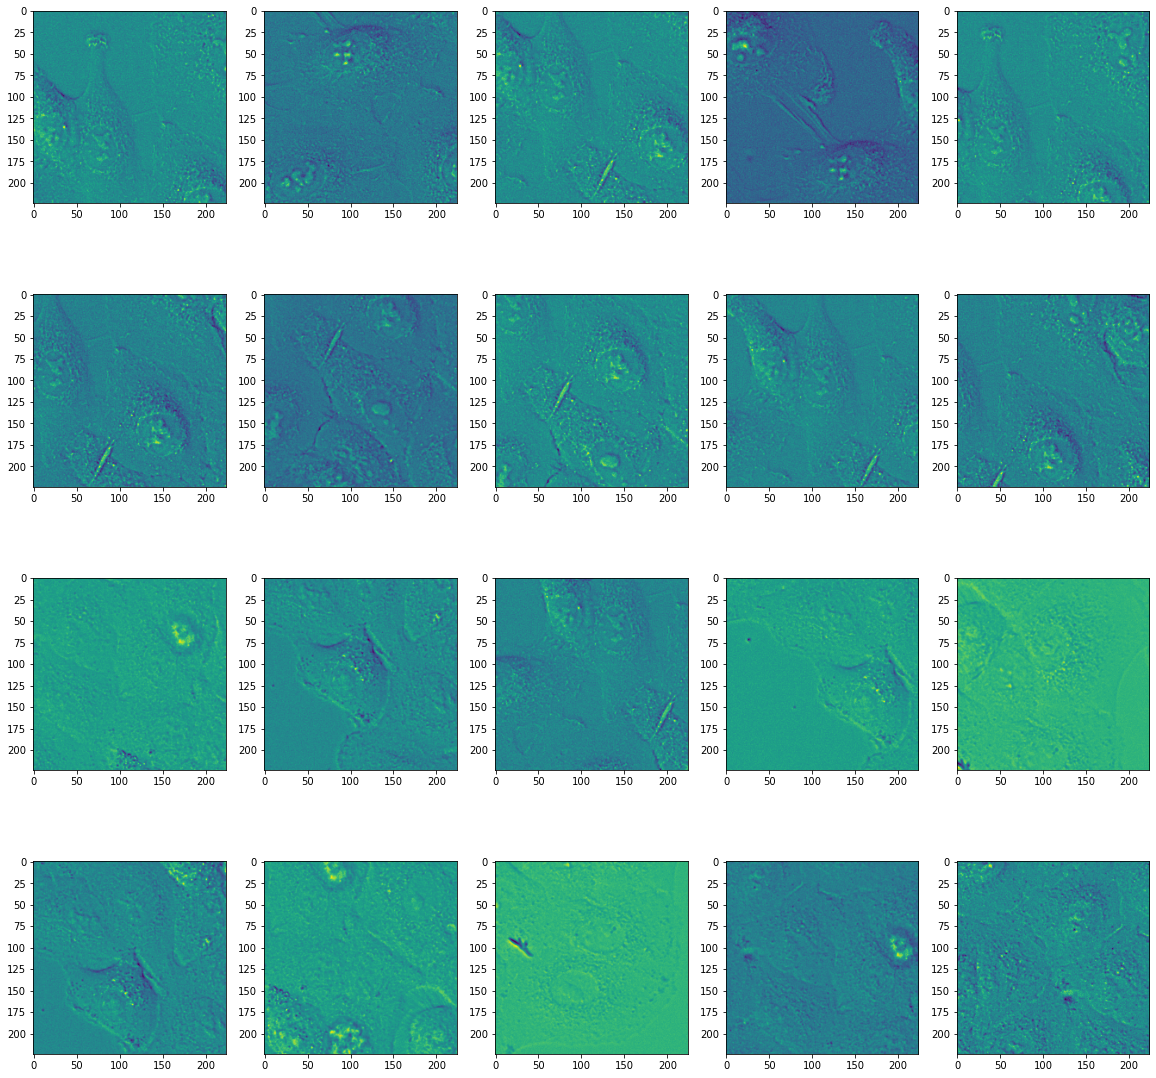

In [21]:
folder_img_show(train_img_path)

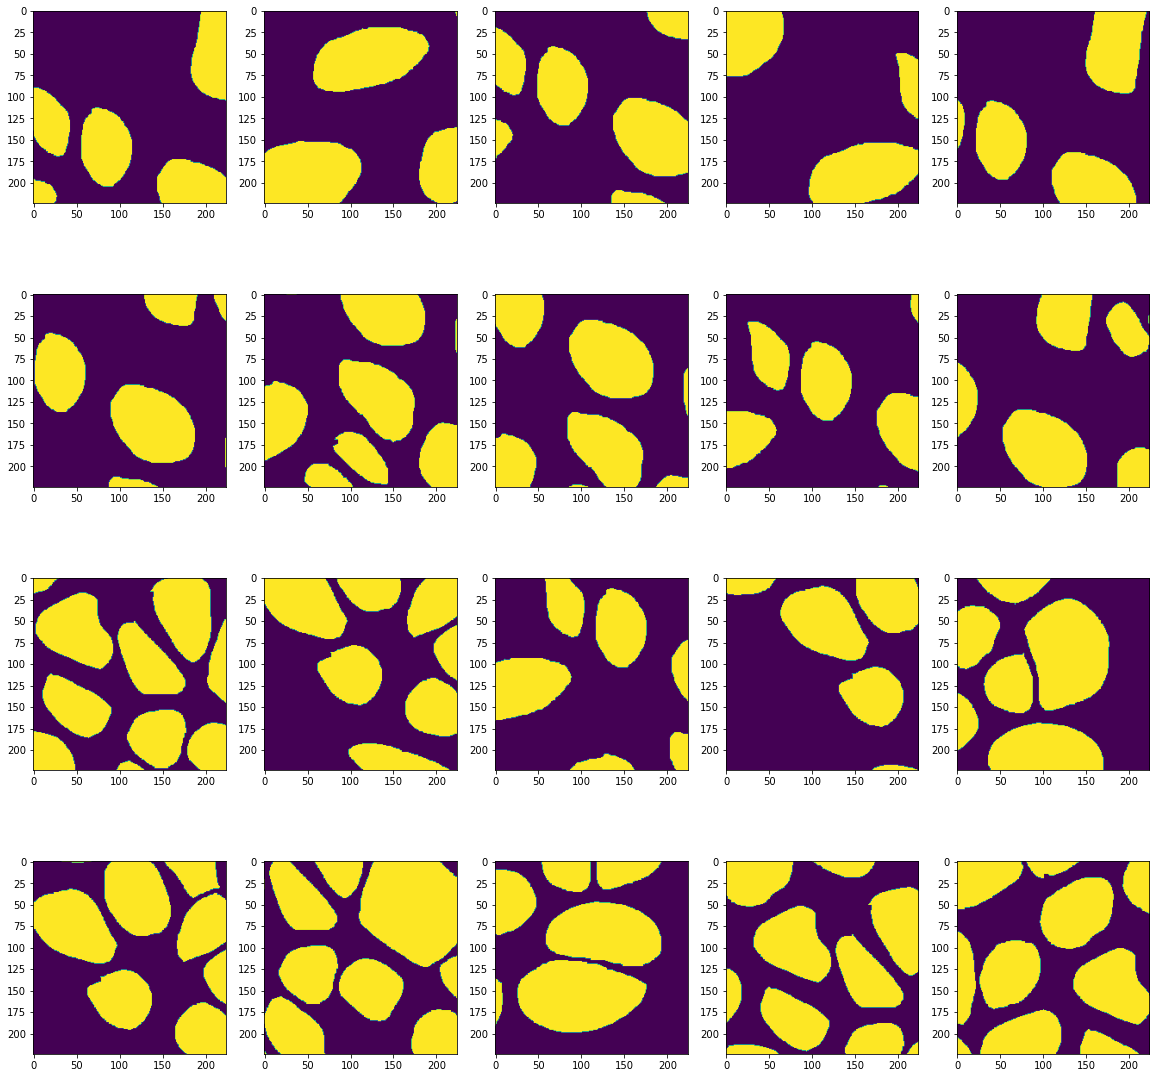

In [22]:
folder_img_show(train_interior_path)

# check crop folder purity

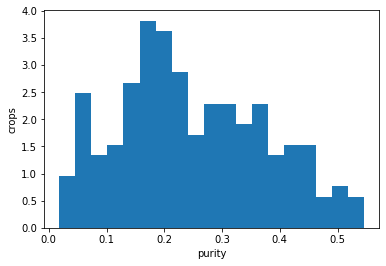

In [60]:
purity_index = np.zeros(len(img_str))
for img_idx in range(len(img_str)):
    interior = imread(interior_str[img_idx])
    purity = np.sum((interior!=0)*1)/interior.size
    purity_index[img_idx] = purity
n_bin = math.ceil(len(img_str)/10)
plt.hist(purity_index, density=True, bins=n_bin)  # density=False would make counts
plt.ylabel('crops')
plt.xlabel('purity');

In [ ]:
0.07
0.25
0.40